In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


OUTPUTPATH = '../output/'
OUTPUTFIGURES = '../figures/'

class get_heatmaps():
    '''Get those heatmaps'''

    def __init__(self, path_to_data, path_to_output, sample):
        self.path_to_data = path_to_data
        self.path_to_output = path_to_output
        self.sample = sample
        with open('../resources/topic_translation') as handle:
               self.translator = json.loads(handle.read()) 

    def get_confusion_matrix(approach, sample, classifier = None):
        if approach == "Dictionary Approach":
            df = pd.read_pickle('/Users/anne/surfdrive/uva/projects/RPA_KeepingScore/data/RPA_and_Buschers_data_with_dictionaryscores.pkl')

            if sample == 'totalsample':
                df = df
            elif sample == 'newspaper_sample_only':
                df = df[df['type'] == 'newspaper']
            elif sample == 'pq_sample_only' :
                df = df[df['type'] == 'parlementary question']
            elif sample == 'RPA_sample' :
                df = df[df['origin'] == 'RPA']
            elif sample == 'Bjorns_sample' :
                df = df[df['origin'] == 'Bjorn']

            df = df[['main_topic_label', 'topic_label_dictionary']]
            df.rename(columns={'main_topic_label':'Actual label','topic_label_dictionary':'Predicted label'}, inplace=True)

        elif approach == 'SML':
            base = "{}SML_predicted_actual_{}.json".format(OUTPUTPATH, sample)
            print(base)
            df = pd.read_json(base)
            if classifier == "Passive Agressive":
                df = df[df['Classifier'] == "Passivie Aggressive"]
            if classifier == "SGDClassifier":
                df = df[df['Classifier'] == "SGDClassifier"]
            if classifier == "Naive Bayes":
                df = df[df['Classifier'] == "Naive Bayes"]

        df.replace(translation, inplace=True)
        confusion_matrix = pd.crosstab(df['Actual label'], df['Predicted label'], rownames=['True'], colnames=['Predicted'])
        cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        return cmn

    def get_heatmap(approach, sample, classifier):
        label = "Values in the diagonal represent the relative times that the manual coding (’true label’ - Y axis ) is equal to the classifier (X axis). Diagonal values indicate the relative number of correct predictions: The higher the values in diagonal, the better the prediction. Off-diagonal values indicate misclassification. Darker colours indicate higher values. Due to class imbalance, values are normalised to facilitate visual understanding. Values below 0.1 are not visualised. "
        cmn = get_confusion_matrix(approach, sample, classifier)
        cmn = cmn.round(1)
        fig, ax = plt.subplots(figsize=(10,10))
        heatmap = sns.heatmap(cmn, annot=True, annot_kws={"size": 10}, fmt='.1f',  cmap="YlGnBu", mask=(cmn<0.1))
        fs = 12
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fs)
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fs)
        plt.title("Normalized Confusion Matrix (Classifier: {}) ".format(approach), fontsize= 16)
        plt.ylabel('True label (Manual coding)', fontsize=fs)
        plt.xlabel('Predicted label', fontsize=fs)
        return fig

    def get_figure_save(approach, sample, classifier = None):
        #logger.info('{}'.format(label))
        figure = get_heatmap(approach, sample, classifier = None)
        if approach == 'SML':
            fname = '{}Heatmap_{}_{}_{}'.format(OUTPUTFIGURES, approach, classifier, sample)
        else:
             fname = '{}Heatmap_{}_{}'.format(OUTPUTFIGURES, approach, sample)
        figure.savefig(fname, bbox_inches='tight')
        print('Saved figure as: {}'.format(fname))


In [ ]:
get_figure_save('Dictionary Approach', 'totalsample')
get_figure_save('Dictionary Approach', 'RPA_sample')
get_figure_save('Dictionary Approach', 'Bjorns_sample')
get_figure_save('Dictionary Approach', 'newspaper_sample_only')
get_figure_save('Dictionary Approach', 'parlementary question')

get_figure_save('SML', 'totalsample', 'Passive Aggressive')
get_figure_save('SML', 'totalsample', 'Naive Bayes')
get_figure_save('SML', 'totalsample', 'SGDClassifier')

get_figure_save('SML', 'RPA_sample', 'Passive Aggressive')
get_figure_save('SML', 'RPA_sample', 'Naive Bayes')
get_figure_save('SML', 'RPA_sample', 'SGDClassifier')

In [11]:
def get_recall_precision():
    topics = list(df['main_topic_label'].unique())
    
    true_positives = ["_tp " + str(i) for i in topics]
    false_positives = ["_fp " + str(i) for i in topics]
    false_negatives = ["_fn " + str(i) for i in topics]
    
    true_positives_st = ["st_tp " + str(i) for i in topics]
    false_positives_st = ["st_fp " + str(i) for i in topics]
    false_negatives_st = ["st_fn " + str(i) for i in topics]
   
    recall = {}
    precision = {}
    
    recall_stemmed = {}
    precision_stemmed = {}
    
    for tp, fp, fn, st_tp, st_fp, st_fn, topic in zip(true_positives, false_positives, false_negatives, true_positives_st, false_positives_st, false_negatives_st, topics) :   
        
        recall['recall ' + str(topic)] = df[tp].sum(axis=0) / ( df[tp].sum(axis=0) + df[fn].sum(axis=0) )
        precision['precision ' + str(topic)] = df[tp].sum(axis=0) / ( df[tp].sum(axis=0) + df[fp].sum(axis=0) )
        
        recall_stemmed['recall ' + str(topic)] = df[st_tp].sum(axis=0) / ( df[st_tp].sum(axis=0) + df[st_fn].sum(axis=0) )
        precision_stemmed['precision ' + str(topic)] = df[st_tp].sum(axis=0) / ( df[st_tp].sum(axis=0) + df[st_fp].sum(axis=0) )

    recall['recall total'] = sum(recall.values()) / len(recall.values())
    precision['precision total'] = sum(precision.values()) / len(precision.values())
    recall_stemmed['recall total'] = sum(recall_stemmed.values()) / len(recall_stemmed.values())
    precision_stemmed['precision total'] = sum(precision_stemmed.values()) / len(precision_stemmed.values())
    
    return recall, precision, recall_stemmed, precision_stemmed

In [25]:
# get final df:
def main():
    df = get_tp_fp_fn()
    # check whether all went ok
    print("A sample to check whether all went okay: ")
    print(df[df['main_topic_label'] == 'Overige'][['main_topic_label', 'topic_label_dictionary_minmatches', '_tp Overige', '_fp Overige', '_fn Overige']].head(10))
    
if __name__ == '__main__':
    logger = logging.getLogger()
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s')
    logging.root.setLevel(level=logging.INFO)
    
    main()

NameError: name 'logger' is not defined

In [15]:
df.to_pickle(PATH_TO_DATA + 'all_data.pkl')

In [16]:
#get precision and recall for dictionary items

In [17]:
for t, s in recall.items():
    print('{} -- {}'.format(t, s))
    
print()

for t, s in precision.items():
    print('{} -- {}'.format(t, s))

print()

    
for t, s in recall_stemmed.items():
    print('{} -- {}'.format(t, s))
    
print()

for t, s in precision_stemmed.items():
    print('{} -- {}'.format(t, s))

recall Onderwijs -- 0.41901408450704225
recall Burgerrechten en vrijheden -- 0.017057569296375266
recall Justitie, Rechtspraak, Criminaliteit -- 0.17144808743169399
recall Defensie -- 0.19556451612903225
recall Gezondheid -- 0.2334293948126801
recall Gemeenschapsontwikkeling, huisvestingsbeleid en stedelijke planning -- 0.060109289617486336
recall Functioneren democratie en openbaar bestuur -- 0.02122347066167291
recall Macro-economie en belastingen -- 0.15767634854771784
recall Buitenlandse zaken en ontwikkelingssamenwerking -- 0.032357473035439135
recall Ondernemingen, Bankwezen en binnenlandse handel  -- 0.1109375
recall Arbeid -- 0.1038961038961039
recall Verkeer en vervoer -- 0.10266159695817491
recall Overige -- 0.9449177729344165
recall sociale Zaken -- 0.01
recall Immigratie en integratie -- 0.10038610038610038
recall Landbouw en Visserij -- 0.345
recall Energiebeleid -- 0.1223021582733813
recall Milieu -- 0.07936507936507936
recall Wetenschappelijk onderzoek, technologie en co

In [21]:
df[df['type'] != 'newspaper']

,documentnr,main_topic_label,origin,text_x,topic,type,topic_label_dictionary,index_words,smallest_index,len matches,...,_fn Milieu,st_tp Milieu,st_fp Milieu,st_fn Milieu,"_tp Wetenschappelijk onderzoek, technologie en communicatie","_fp Wetenschappelijk onderzoek, technologie en communicatie","_fn Wetenschappelijk onderzoek, technologie en communicatie","st_tp Wetenschappelijk onderzoek, technologie en communicatie","st_fp Wetenschappelijk onderzoek, technologie en communicatie","st_fn Wetenschappelijk onderzoek, technologie en communicatie"
677,677,"Justitie, Rechtspraak, Criminaliteit",RPA,1 Hebt u het voornemen de examinering van poli...,12,parlementary question,Overige,NaN,NaN,0.0,...,0,0,0,0,0,0,0,0,0,0
678,678,"Justitie, Rechtspraak, Criminaliteit",RPA,1 Hebt u het voornemen de examinering van poli...,12,parlementary question,Overige,NaN,NaN,0.0,...,0,0,0,0,0,0,0,0,0,0
679,679,Macro-economie en belastingen,RPA,1 Hoe valt het antwoord van de minister van Fi...,1,parlementary question,"Ondernemingen, Bankwezen en binnenlandse handel",[51],51.0,1.0,...,0,0,0,0,0,0,0,0,0,0
680,680,"Ondernemingen, Bankwezen en binnenlandse handel",RPA,1 Hoe valt het antwoord van de minister van Fi...,15,parlementary question,"Ondernemingen, Bankwezen en binnenlandse handel",[51],51.0,1.0,...,0,0,0,0,0,0,0,0,0,0
681,681,"Ondernemingen, Bankwezen en binnenlandse handel",RPA,1 Hebt u kennis genomen van de in opdracht van...,15,parlementary question,Overige,NaN,NaN,0.0,...,0,0,0,0,0,0,0,0,0,0
682,682,Macro-economie en belastingen,RPA,1 Hebt u kennis genomen van de in opdracht van...,1,parlementary question,Overige,NaN,NaN,0.0,...,0,0,0,0,0,0,0,0,0,0
683,683,Verkeer en vervoer,RPA,"1 Deelt u de mening, dat strafrechtelijke midd...",10,parlementary question,Overige,NaN,NaN,0.0,...,0,0,0,0,0,0,0,0,0,0
684,684,"Justitie, Rechtspraak, Criminaliteit",RPA,"1 Deelt u de mening, dat strafrechtelijke midd...",12,parlementary question,Overige,NaN,NaN,0.0,...,0,0,0,0,0,0,0,0,0,0
685,685,Milieu,RPA,1 Kent u het bericht als zouden de Verenigde S...,7,parlementary question,Overige,NaN,NaN,0.0,...,1,0,0,1,0,0,0,0,0,0
686,686,Energiebeleid,RPA,1 Kent u het bericht als zouden de Verenigde S...,8,parlementary question,Overige,NaN,NaN,0.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# visualize 

In [22]:
len(df['topic_label_dictionary_minmatches'].unique())

19

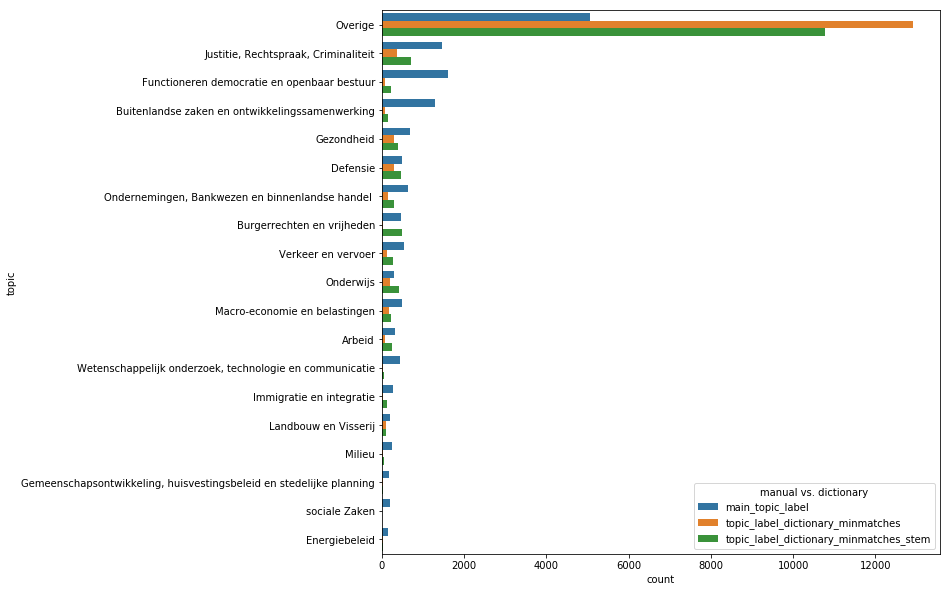

In [23]:
df['id'] = df.index
melted = pd.melt(df, id_vars=['id'], value_vars=['main_topic_label', 'topic_label_dictionary_minmatches','topic_label_dictionary_minmatches_stem'], var_name='manual vs. dictionary', value_name='topic')

plt.rcParams['figure.figsize']=(10,10)
ax = sns.countplot(y="topic", hue='manual vs. dictionary', 
                   order = melted['topic'].value_counts().index, data=melted)

In [24]:
len(df)

14991

In [75]:
len(pl)
57892

28058

In [954]:
# print dataframe, transformed: grouped by document and only the max length matches
#idx = df2.groupby(['documentnr'], sort=False)['len matches'].transform(max) == df2['len matches']
#df2[idx].head()

In [61]:
import embeddingvectorizer
from sklearn.metrics import precision_recall_fscore_support as score
from gensim.models.word2vec import Word2Vec
import gensim
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier

In [53]:
np = df[df['type'] == 'newspaper']

In [54]:
import pandas as pd

PATH_TO_DATA = '~/surfdrive/uva/projects/RPA_KeepingScore/pickle_files/'
df = pd.read_pickle(PATH_TO_DATA + 'all_data.pkl')
df['main_topic_id']  = df['main_topic_label'].factorize()[0]


x_np = np.text_x.to_list()
y_np = np.main_topic_label.to_list()

X_train, X_test, y_train, y_test = train_test_split(x_np, y_np, test_size=0.2, random_state=42)

#predicted_svm = count_svm.fit(X_train, y_train).predict(X_test)
#precision_svm, recall_svm, fscore_svm , support_svm = score(y_test, predicted_svm, average='macro')

In [63]:
aem_300d_tfidf_ET.fit(X_train, y_train)
preds = aem_300d_tfidf_ET.predict(X_test)
print(classification_report(y_test, preds))

                                                                     precision    recall  f1-score   support

                                                             Arbeid       0.42      0.25      0.31        44
                    Buitenlandse zaken en ontwikkelingssamenwerking       0.50      0.61      0.55       231
                                         Burgerrechten en vrijheden       0.50      0.01      0.03        69
                                                           Defensie       0.80      0.19      0.30        86
                                                      Energiebeleid       0.00      0.00      0.00        19
                        Functioneren democratie en openbaar bestuur       0.59      0.63      0.61       324
Gemeenschapsontwikkeling, huisvestingsbeleid en stedelijke planning       0.25      0.04      0.07        26
                                                         Gezondheid       0.69      0.40      0.50        83
                  

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [65]:
clf_pipeline.fit(X_train, y_train)
preds = clf_pipeline.predict(X_test)
print(classification_report(y_test, preds))

                                                                     precision    recall  f1-score   support

                                                             Arbeid       0.43      0.34      0.38        44
                    Buitenlandse zaken en ontwikkelingssamenwerking       0.54      0.57      0.55       231
                                         Burgerrechten en vrijheden       0.23      0.10      0.14        69
                                                           Defensie       0.49      0.41      0.44        86
                                                      Energiebeleid       0.33      0.05      0.09        19
                        Functioneren democratie en openbaar bestuur       0.58      0.66      0.62       324
Gemeenschapsontwikkeling, huisvestingsbeleid en stedelijke planning       0.42      0.19      0.26        26
                                                         Gezondheid       0.66      0.53      0.59        83
                  

In [67]:
aem_pipeline.fit(X_train, y_train)
preds = aem_pipeline.predict(X_test)
print(classification_report(y_test, preds))

                                                                     precision    recall  f1-score   support

                                                             Arbeid       0.31      0.25      0.28        44
                    Buitenlandse zaken en ontwikkelingssamenwerking       0.56      0.41      0.47       231
                                         Burgerrechten en vrijheden       0.26      0.20      0.23        69
                                                           Defensie       0.61      0.22      0.32        86
                                                      Energiebeleid       0.26      0.63      0.37        19
                        Functioneren democratie en openbaar bestuur       0.40      0.75      0.52       324
Gemeenschapsontwikkeling, huisvestingsbeleid en stedelijke planning       0.24      0.27      0.25        26
                                                         Gezondheid       0.46      0.57      0.51        83
                  

In [44]:
clf = gs_clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print("{} score: {}".format(name, score))
    print("{} are the best estimators".format(clf.best_estimator_))
    print(classification_report(clf.best_estimator_.predict(X_test), y_test))

NameError: name 'sklearn' is not defined

In [31]:
mod = gensim.models.Word2Vec.load('~/repos/embedding_models/w2v_model_nr_7_window_10_size_300_negsample_15')
aem_300d = {w: vec for w, vec in zip(mod.wv.index2word, mod.wv.syn0)}

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  


In [42]:
aem_300d_tfidf_ET = Pipeline([
    ("word2vec Count vectorizer", embeddingvectorizer.EmbeddingTfidfVectorizer(aem_300d)),
    ("ExtraTrees", ExtraTreesClassifier(n_estimators=200))
    ])

In [ ]:
clf_pipeline = Pipeline([('vect', CountVectorizer() ),
    ("svm", SGDClassifier(loss='hinge', penalty='l2', tol=1e-4, alpha=1e-6, max_iter=1000, random_state=42))
    ])

In [62]:
clf_pipeline = Pipeline([('vect', TfidfVectorizer() ),
    ("svm", SGDClassifier(loss='hinge', penalty='l2', tol=1e-4, alpha=1e-6, max_iter=1000, random_state=42))
    ])

In [66]:
aem_pipeline = Pipeline([("word2vec Count vectorizer", embeddingvectorizer.EmbeddingTfidfVectorizer(aem_300d)),
    ("svm", SGDClassifier(loss='hinge', penalty='l2', tol=1e-4, alpha=1e-6, max_iter=1000, random_state=42))
    ])